todo:
- make check if done, template matching on clouds
- or first teach it 1v1 in marathon mode detect points or even time by every time the time refreshes you get another score?

Environment Configuration
- Start Dolphin
- Load save state f1
- in the worst case scenario set it up manually player1=ash player2=gary

1. Imports Versioning

In [16]:
import gymnasium as gym
import matplotlib
import torch
import torchvision
import torchaudio
import pyautogui
import numpy as np

print(gym.__version__)          # 0.29.1
print(matplotlib.__version__)   # 3.9.2
print(torch.__version__)        # 2.4.1+cpu
print(torchvision.__version__)  # 0.19.1+cpu
print(torchaudio.__version__)   # 2.4.1+cpu
print(pyautogui.__version__)    # 0.9.54
print(np.__version__)           # 1.26.4

0.29.1
3.9.2
2.4.1+cpu
0.19.1+cpu
2.4.1+cpu
0.9.54
1.26.4


2. Initialise Environment, Model & Agent

In [ ]:
from DQNCNN import DQNCNN
from DQNAgent import DQNAgent
from PPLEnv import PPLEnv

# States
P1_CELL_BBOX_PJ64 = (348, 130, 830, 1004)
P1_CELL_BBOX_DOLPHIN = (390, 160, 845, 960)
STACK_SIZE = 4 # amount of frames stacked
CHANNEL_AMOUNT = 3 # RGB

env = PPLEnv(state_bbox=P1_CELL_BBOX_DOLPHIN, color_mode='color', stack_size=STACK_SIZE)
ACTION_SIZE = env.action_space.n
deep_q_learning_model = DQNCNN(action_size=ACTION_SIZE, stack_size=STACK_SIZE, channels=CHANNEL_AMOUNT)
agent = DQNAgent(DQNCNN=deep_q_learning_model, action_size=ACTION_SIZE)
env.action_space.n

6

3. Training Loop

In [ ]:
from helper import alt_tab
import time
import keyboard

# Training loop
num_episodes = 10
agent.q_network.train()
agent.epsilon = 1.0

alt_tab() # alt tab to the game
for e in range(num_episodes):
    # Reset the environment and get the initial state (stacked frames managed by PPLEnv)
    state, _ = env.reset()  # Initial state, includes stacked frames
    done = False
    
    while not done:
        # Use the state directly as the stacked frames (already handled by PPLEnv)
        action = agent.select_action(state)  # Select action (can be exploration or exploitation)
        
        # Perform the action in the environment and get the next state and reward
        next_state, reward, done, _, _ = env.step(action)
        print(f'Reward: {reward}')

        # Store experience in replay memory
        agent.memory.add((state, action, reward, next_state, done))

        # Train the agent with experience replay
        agent.replay()

        # Update the state (stacked frames already handled by PPLEnv)
        state = next_state  # Update to the new state (stacked frame after the action)
        

        # Periodically update target network
        if e % agent.update_frequency == 0:
            agent.update_target_network()

    print(f"Episode: {e+1}/{num_episodes}, Total Reward: {env.episode_score}")

env.close()
alt_tab() # alt tab out the game


Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 1
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 1
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 30
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 10
Reward: 0
Reward: 10
Reward: 10
Reward: 10
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 1
Reward: 0
Reward: 1
Reward: 0
Reward: 0
Reward: 0
Episode: 1/2, Total Reward: 74
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 1
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Rewa

4. Save Model

In [6]:
torch.save(agent.q_network.state_dict(), "dqn_model_lv8_f2_500.pth")
print("Model saved!")

Model saved!


5. Load Model

In [3]:
agent.q_network = DQNCNN(action_size=ACTION_SIZE, stack_size=STACK_SIZE, channels=3)
agent.q_network.load_state_dict(torch.load("dqn_model_500.pth"))

C:\Users\Kaan\AppData\Local\Temp\ipykernel_25668\1819184054.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.q_network.load_state_dict(torch.load("dqn_model_500.pth

<All keys matched successfully>

5. Test Loop

In [9]:
import time
import keyboard
from helper import alt_tab

# Test loop
num_test_episodes = 1  # Number of test episodes
alt_tab()  # Bring the game window to the foreground

# Set agent to evaluation mode
agent.q_network.eval()
agent.epsilon = 0.0  # Ensure no exploration during testing (greedy policy)

for e in range(num_test_episodes):
    # Reset the environment and get the initial state
    state, _ = env.reset()
    done = False
    
    while not done:
        # Select the best action based on the current policy
        action = agent.select_action(state, explore=False)
        
        # Perform the action in the environment and get the next state and reward
        next_state, reward, done, _, _ = env.step(action)
        
        # Update the state
        state = next_state
    
    print(f"Test Episode: {e+1}/{num_test_episodes}, Total Reward: {env.episode_score}")

env.close()
alt_tab()


Test Episode: 1/1, Total Reward: 0


# Results
Reward +1 for surviving a frame
- on average suvrives for 10 seconds without training
- on average survives for 30 seconds after some  (500 eps)

# You are entering the kitchen

### Read Memory

In [27]:
import ctypes
import psutil

# now read the adres

# Constants
PROCESS_ALL_ACCESS = 0x1F0FFF

# Function to get the process ID
def get_process_id(process_name):
    for proc in psutil.process_iter(['pid', 'name']):
        if proc.info['name'] == process_name:
            return proc.info['pid']
    return None

# Function to read memory from a given process at a specific address
def read_memory(process_handle, address, data_type=ctypes.c_uint64):
    value = data_type()
    bytes_read = ctypes.c_size_t()
    result = ctypes.windll.kernel32.ReadProcessMemory(process_handle,ctypes.c_void_p(address),ctypes.byref(value),ctypes.sizeof(value),ctypes.byref(bytes_read))
    if result:
        return value.value
    else:
        error_code = ctypes.GetLastError()
        print(f"Failed to read memory. Error code: {error_code}")
        return None

# Main validation
process_name = "DolphinMemoryEngine.exe"
process_id = get_process_id(process_name)

# Open the process
process_handle = ctypes.windll.kernel32.OpenProcess(PROCESS_ALL_ACCESS, False, process_id)
if process_handle:
    base_address = 0x7FF9E8A90000 # Qt6Gui.dll
    base_offset = 0x006EA868
    offsets = [0xC38, 0x190, 0x750]

    first_pointer = base_address + base_offset
    dereferenced_address  = read_memory(process_handle, first_pointer, data_type=ctypes.c_uint64)
    dereferenced_address_hex = (hex(dereferenced_address))
    print(dereferenced_address_hex)

    for offset in offsets:
        pointer = dereferenced_address + offset
        print(f'Pointer Addre: {hex(pointer)}')
        dereferenced_address  = read_memory(process_handle, pointer)
        print(f'Address Value: {dereferenced_address}')
        dereferenced_address_hex = (hex(dereferenced_address))
        print(dereferenced_address_hex)
a = read_memory(process_handle, pointer, data_type=ctypes.c_uint32)
print(a)
print(type(a))

0x220a1c3edb0
Pointer Addre: 0x220a1c3f9e8
Address Value: 2339176184304
0x220a1c3f9f0
Pointer Addre: 0x220a1c3fb80
Address Value: 2339176188720
0x220a1c40b30
Pointer Addre: 0x220a1c41280
Address Value: 72340172821236586
0x101010100000b6a
2922
<class 'int'>


In [ ]:
process_name = "DolphinMemoryEngine.exe"
process_id = get_process_id(process_name)
base_address = 0x7FF9E8A90000 # Qt6Gui.dll
base_offset = 0x006EA868
offsets = [0xC38, 0x190, 0x750]

first_pointer = base_address + base_offset
dereferenced_address  = read_memory(process_handle, first_pointer, data_type=ctypes.c_uint64)
dereferenced_address_hex = (hex(dereferenced_address))

for offset in offsets:
    pointer = dereferenced_address + offset
    dereferenced_address  = read_memory(process_handle, pointer)
    dereferenced_address_hex = (hex(dereferenced_address))

read_memory(process_handle, pointer, data_type=ctypes.c_uint32)


0.0


### Getting Pixel Color

In [5]:
import pyautogui
from PIL import ImageGrab

# Coordinates of the pixel (x, y)
x, y = 100, 150  # Example coordinates (100, 150)

# Capture the screen at a single pixel location
screenshot = ImageGrab.grab(bbox=(x, y, x+1, y+1))  # Captures a 1x1 pixel region

# Get the color of the pixel at (x, y)
pixel_color = screenshot.getpixel((0, 0))  # (0, 0) because it's a 1x1 region

# Print the color
print(f"The color of the pixel at ({x}, {y}) is: {pixel_color}")

The color of the pixel at (100, 150) is: (24, 24, 24)


In [26]:
import pyautogui
from PIL import ImageGrab, ImageDraw

# Coordinates of the pixel (x, y)
x, y = 400, 965  # Example coordinates (100, 150)

# Capture the screen at a single pixel location
alt_tab()
range=40
screenshot = ImageGrab.grab(bbox=(400, 965, 440, 1005))  # 10x10 region centered on the pixel

# Show the screenshot with the red circle
screenshot.show()

# Get the color of the pixel at (x, y)
pixel_color = screenshot.getpixel((3, 3))  # The pixel is at the center of the 10x10 region

# Print the color
print(f"The color of the pixel at ({x}, {y}) is: {pixel_color}")
alt_tab()

The color of the pixel at (400, 965) is: (75, 89, 190)


### Visualize what the model sees

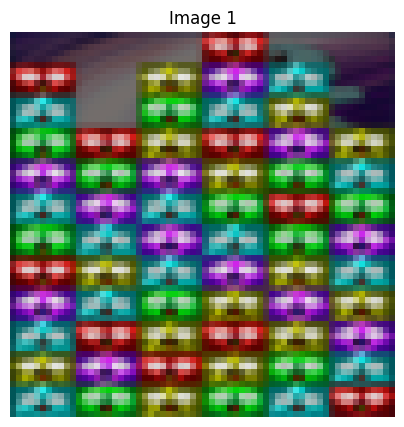

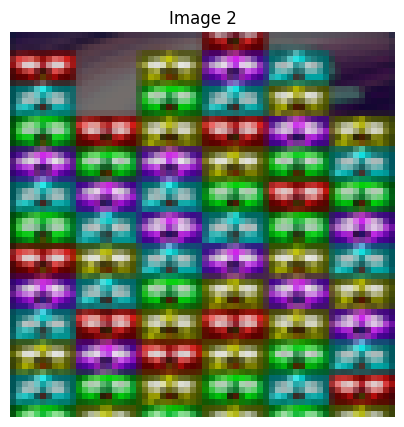

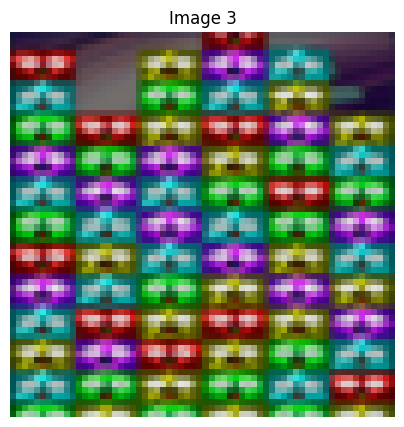

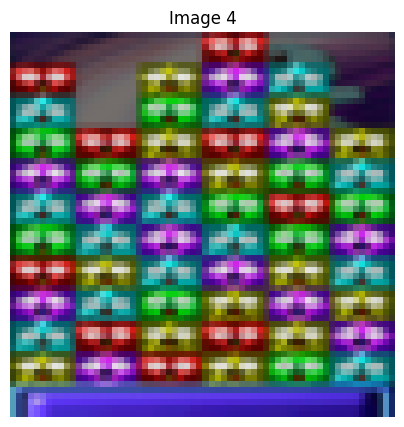

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import deque


frames = env.frames

# Loop through the deque and visualize each tensor
for i, frame in enumerate(frames):
    # Convert the tensor to a NumPy array
    image_array = frame.numpy()

    # Rearrange dimensions from [C, H, W] to [H, W, C] for visualization
    image_array = np.transpose(image_array, (1, 2, 0))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image_array)
    plt.title(f"Image {i + 1}")
    plt.axis("off")
    plt.show()